In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# initial displacement
def phi(x):
    return np.maximum(1-np.abs(x),0)

# phi' with corners smoothed out by averaging neighboring values
def dphi(x):
    if x<-1:
        return 0
    elif x == -1:
        return 0.5
    elif -1<x<0:
        return 1
    elif x == 0:
        return 0
    elif 0<x<1:
        return -1
    elif x == 1:
        return -0.5
    else:
        return 0

# initial velocity
def psi(x):
    return 0

In [3]:
def iterate_advection_sol(u_curr,a,k,h,method,n=1):
    nu = a*k/h
    u = u_curr[n,:]
    m = np.size(u)
    v = np.zeros(m)
    p = np.array(range(m))
    
    if method == 0: # Lax-Friedrichs
        for j in p:
            v[j] = 1/2*((1-nu)*u[(j+1)%m]+(1+nu)*u[(j-1)%m])
        
    if method == 1: # Upwind
        if a>0: # left
            for j in p:
                v[j] = u[j] - nu*(u[j]-u[(j-1)%m])
        else: # right
            for j in p:
                v[j] = u[j] - nu*(u[(j+1)%m]-u[j])
        
    if method == 2: # Lax-Wendroff
        args = 2*np.pi*p/m
        lamb = 1 - nu*1j*np.sin(args) + nu**2*(np.cos(args)-1) # evals
        P = np.zeros((m,m),dtype=np.complex_)
        for j in p:
            P[:,j] = np.exp(1j*args*j) # P
        P_inv = np.linalg.inv(P) # P^-1
        D = np.diag(lamb**(n+1)) # D = D^(n+1)
        u0 = np.reshape(u_curr[0,:],(m,1)) # u^0
        v = P.dot(D).dot(P_inv).dot(u0).flatten() # v = u^(n+1) = P*D*P^-1*u^0
        
    if method == 3: # Beam-Warming
        if a>0: # left
            for j in p:
                uj = u[j]
                uj_1 = u[(j-1)%m]
                uj_2 = u[(j-2)%m]
                v[j] = uj - nu/2*(3*uj-4*uj_1+uj_2) + nu**2/2*(uj-2*uj_1+uj_2)
        else: # right
            for j in p:
                uj = u[j]
                uj_1 = u[(j+1)%m]
                uj_2 = u[(j+2)%m]                
                v[j] = u[j] - nu/2*(-3*uj+4*uj_1-uj_2) + nu**2/2*(uj-2*uj_1+uj_2)

    return v

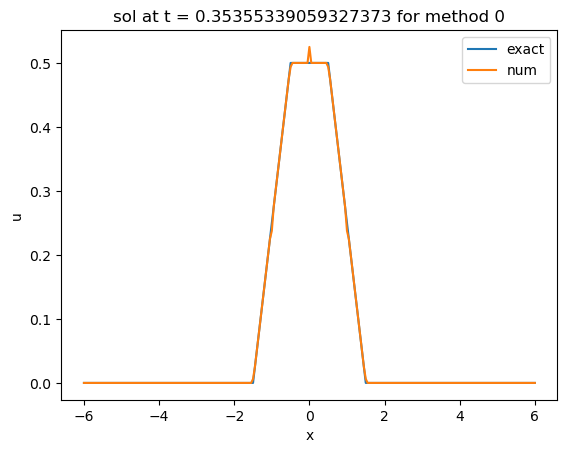

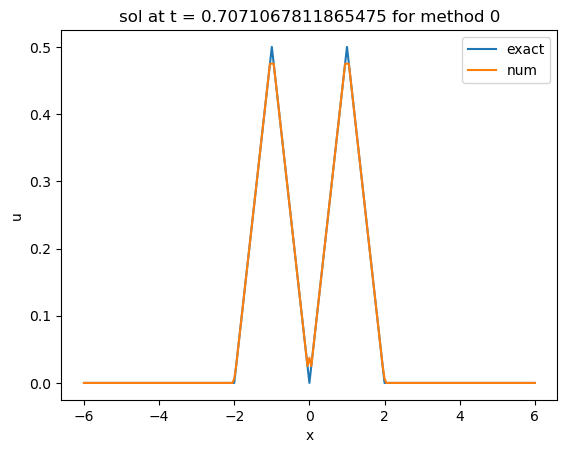

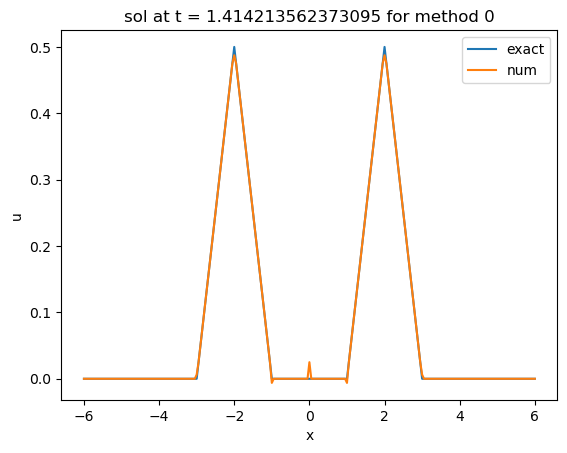

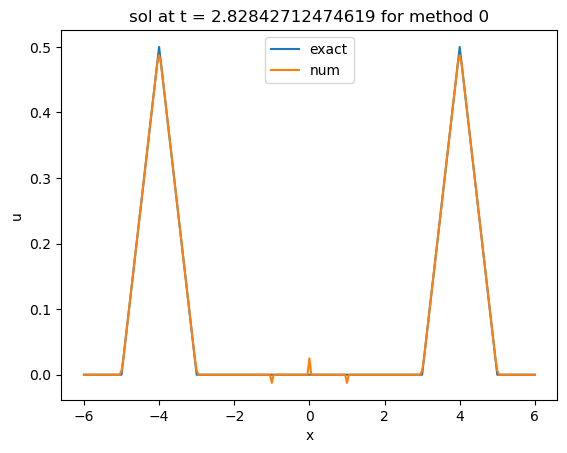

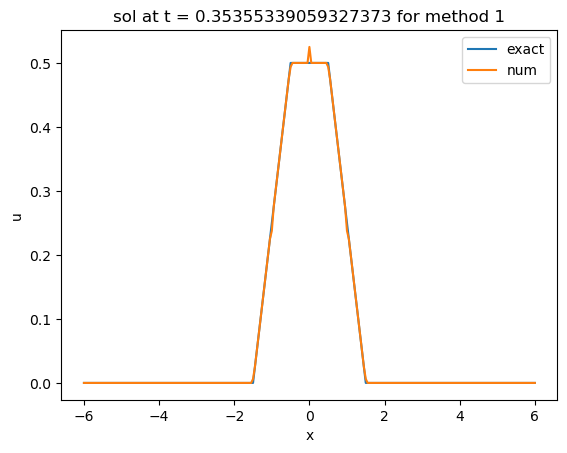

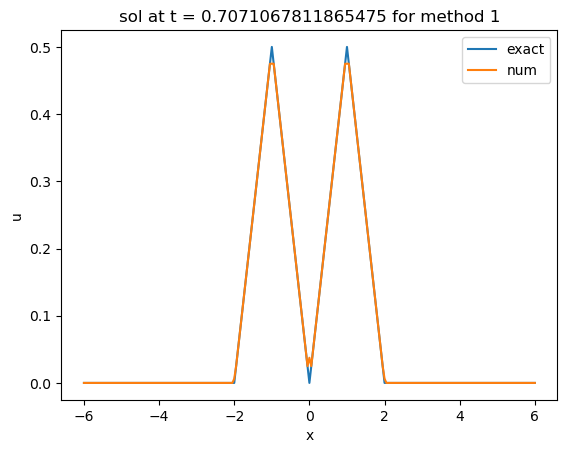

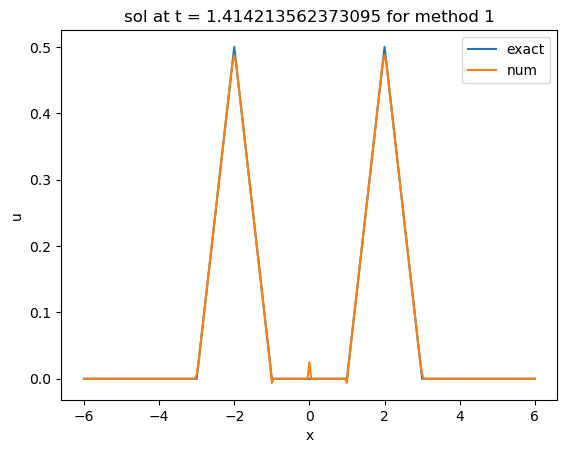

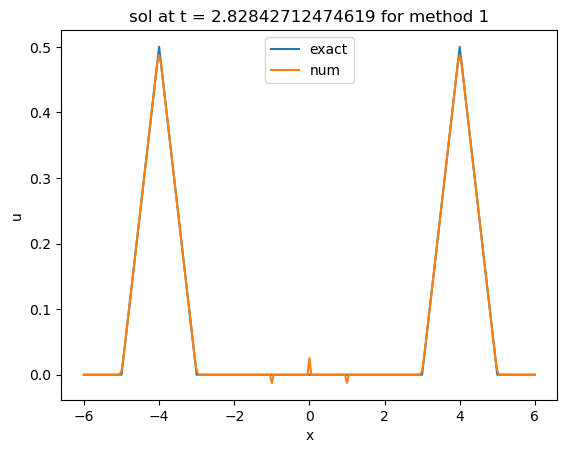

C:\Users\RyanPC\AppData\Local\Temp\ipykernel_14176\1339432174.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  xi[n+1,:] = iterate_advection_sol(xi,-a,k,h,method,n)
C:\Users\RyanPC\AppData\Local\Temp\ipykernel_14176\1339432174.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  eta[n+1,:] = iterate_advection_sol(eta,a,k,h,method,n)


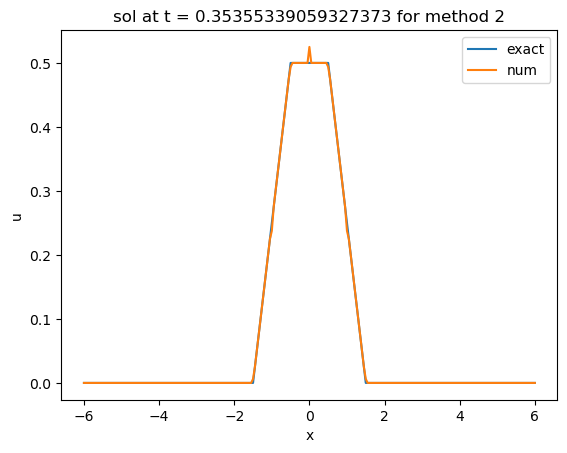

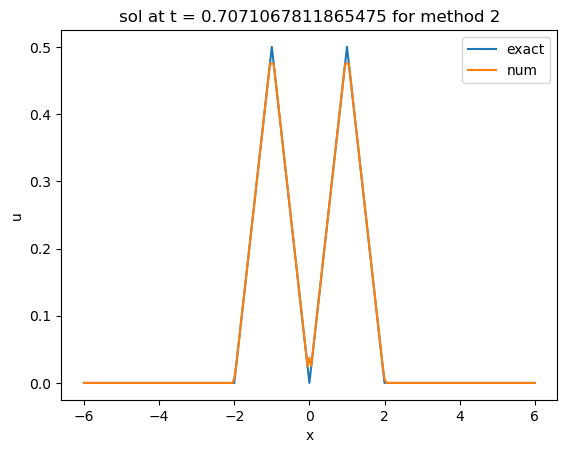

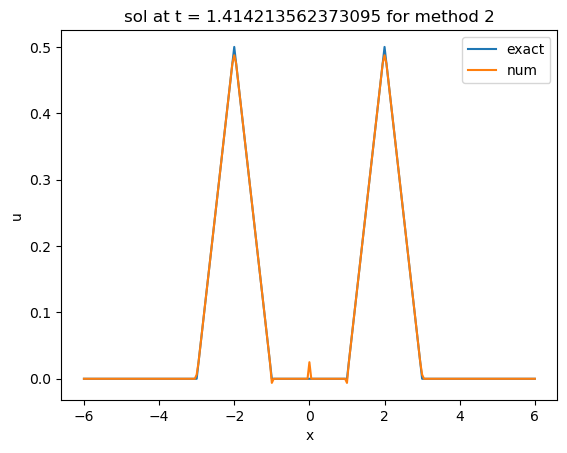

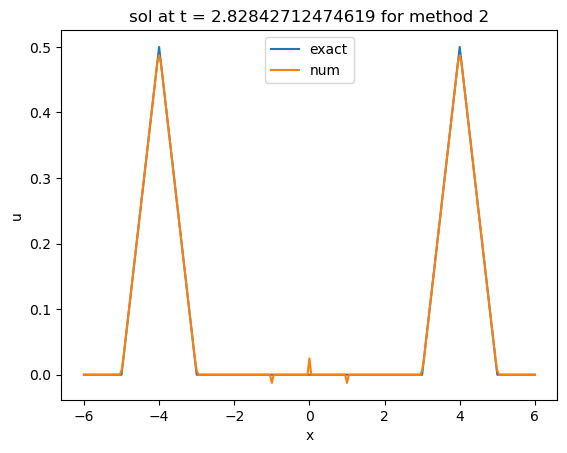

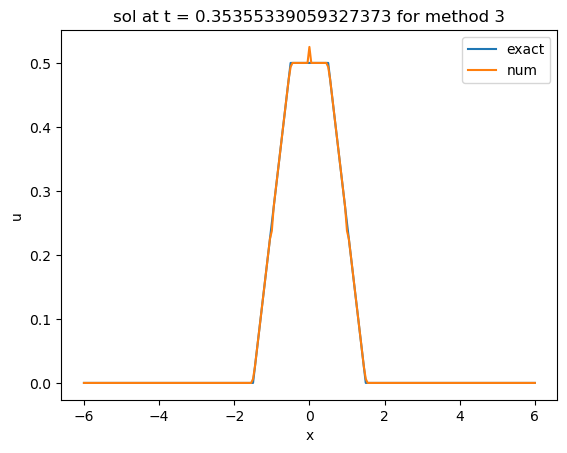

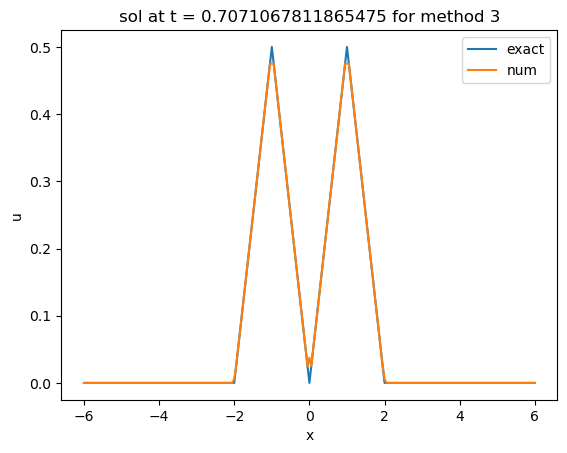

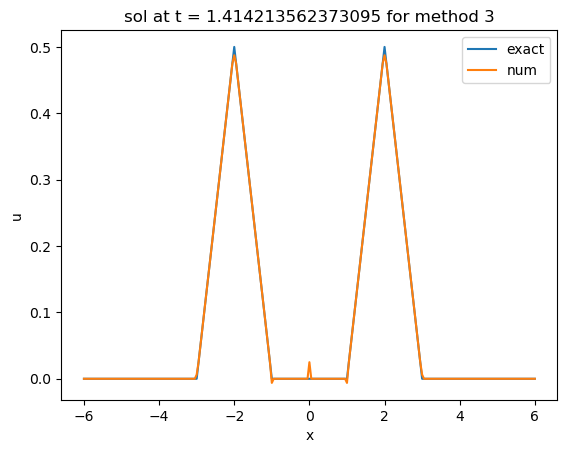

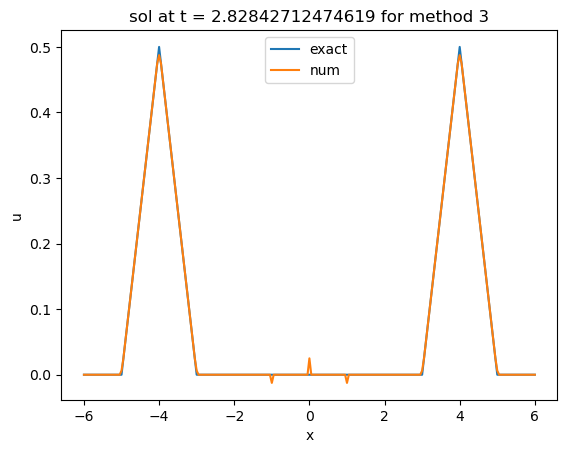

In [4]:
# parameters, mesh, initial conditions
a = np.sqrt(2)
h = 0.05
x_L = -6
x_R = 6
m = int((x_R-x_L)/h)
k = h/a
mesh = np.linspace(x_L,x_R,m+1)
dphi_eval = np.array([dphi(x) for x in mesh])
psi_eval = np.array([psi(x) for x in mesh])
T = 4/a
N = int(T/k)
xi = np.zeros((N+1,m+1))
eta = np.zeros((N+1,m+1))
u = np.zeros((N+1,m+1))
xi[0,:] = 1/(2*a)*(psi_eval+a*dphi_eval)
eta[0,:] = 1/(2*a)*(-psi_eval+a*dphi_eval)
u[0,:] = [phi(x) for x in mesh]

# iterate xi, eta, u
t_plot = [T/8,T/4,T/2,T]
for method in range(4):
    for n in range(N):
        xi[n+1,:] = iterate_advection_sol(xi,-a,k,h,method,n)
        eta[n+1,:] = iterate_advection_sol(eta,a,k,h,method,n)
        f = xi[[n,n+1],:] - eta[[n,n+1],:]
        u[n+1,:] = u[n,:] + a*k/2*(f[0,:]+f[1,:]) # update u by trapezoidal rule
        t = (n+1)*k
        if t in t_plot: # plot u at specific values of t
            u_exact = []
            for x in mesh:
                h0 = 2*h
                m0 = int(2*a*t/h0)
                mesh0 = np.linspace(x-a*t,x+a*t,m0+1)
                psi_eval0 = [psi(x) for x in mesh0]
                u_exact.append(1/2*(phi(x+a*t)+phi(x-a*t)) + 1/(2*a)*np.trapz(psi_eval0,mesh0))
            plt.plot(mesh,u_exact,label='exact')
            plt.plot(mesh,u[n+1,:],label='num')
            plt.legend()
            plt.xlabel('x')
            plt.ylabel('u')
            plt.title('sol at t = {} for method {}'.format(t,method))
            plt.savefig('hw11 sol n = {} method {}.png'.format(n+1,method))
            plt.show()